# Prediction with Tensorflow for the Datasts CDNOW, Grocery, Retail and Moia

## Moia

In [253]:
import random
import datetime
import tensorflow as tf
import tensorflow_probability as tfp
import pyreadr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tqdm.auto import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import helpers.pre_processing as preprocessing
import helpers.post_processing as postprocessing
from dateutil.relativedelta import relativedelta
import importlib
import tensorflow_model.training_model as train_model
import tensorflow_model.prediction_model as pred_model
importlib.reload(pred_model)
importlib.reload(train_model)
importlib.reload(preprocessing)
importlib.reload(postprocessing)

<module 'helpers.post_processing' from '/Users/tom.wuesten/privat_code/CLV/src/CLV/helpers/post_processing.py'>

In [254]:
moia_df = pd.read_csv("data/moia_data.csv")
moia_df = moia_df.drop(columns=["Unnamed: 0"])
moia_df.head()

,date,customer_id,special_trips,amount_trips
0,2022-08-23,5238510068743616989,5,109.0
1,2022-08-23,-3004308863050107066,25,90.0
2,2022-05-24,2991444851614457026,1,66.0
3,2022-05-24,-5875649625272754263,1,148.0
4,2020-08-04,1150417439852075757,0,17.0


In [255]:
moia_launch = "2021-06-09"
cut = "2022-11-04"
moia_df["date"] = pd.to_datetime(moia_df["date"])
moia_df = moia_df[moia_df['date'].dt.strftime('%Y-%m-%d') > moia_launch]
moia_df = moia_df[moia_df['date'].dt.strftime('%Y-%m-%d') < cut]
moia_df["year"] = moia_df["date"].dt.year
moia_df["week"] = (moia_df["date"].dt.dayofyear // 7).clip(
    upper=51
)  # we roll the 52nd week into the 51st

In [256]:
training_start = '2021-06-10'
training_end   = '2022-02-19'
holdout_start  = '2022-02-19'
holdout_end    = '2022-11-03'
date_format    = '%Y-%m-%d'

In [257]:
moia_df.drop_duplicates(["year","week"]).sort_values(by=["date"])

,date,customer_id,special_trips,amount_trips,year,week
1187,2021-06-16,-6878294621826763605,0,11.0,2021,23
1984,2021-06-18,274757813119475708,0,81.0,2021,24
135,2021-06-29,3932833218089440058,1,88.0,2021,25
189,2021-07-02,8936163830146417250,3,107.0,2021,26
225,2021-07-12,6813832657725217681,2,407.0,2021,27
...,...,...,...,...,...,...
1235,2022-09-30,-7114039179293069260,0,211.0,2022,39
264,2022-10-12,-1913609895470123895,1,20.0,2022,40
1409,2022-10-14,-2099303801347401264,18,56.0,2022,41
211,2022-10-22,-4938674031561337960,0,268.0,2022,42


/var/folders/9n/vy16tcl94935dp37ssx_xglw0000gp/T/ipykernel_91125/2942093876.py:4: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  moia_times_series["date"] = moia_times_series["year"] + moia_times_series["relative"]


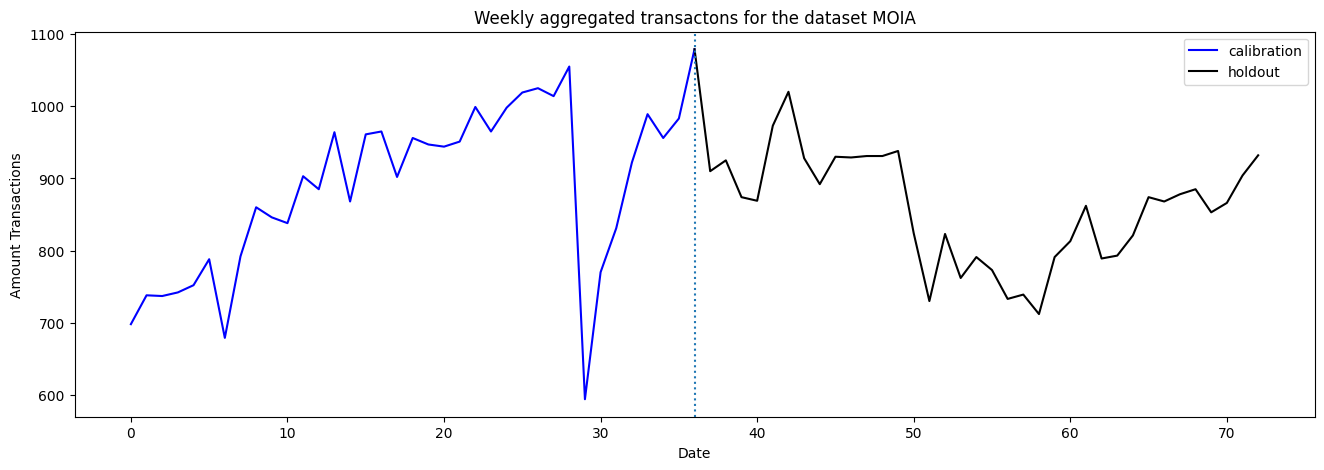

In [258]:
moia_times_series = moia_df.groupby(["year","week"], as_index=False).agg(Trans_count=("date", "count")).sort_values(by=["year","week"]).reset_index(drop=True)
moia_times_series["year"] = moia_times_series["year"].apply(lambda x: pd.to_datetime(datetime.date(int(x), 1, 1)))
moia_times_series["relative"] = moia_times_series["week"].apply(lambda x: relativedelta(weeks=+int(x)))
moia_times_series["date"] = moia_times_series["year"] + moia_times_series["relative"]
plt.figure(figsize=(16,5))
plt.plot(moia_times_series[moia_times_series.date <= "2022-02-19"]["date"].index, 
        moia_times_series[moia_times_series.date <= "2022-02-19"]["Trans_count"], color='blue', label='calibration')
plt.plot(moia_times_series[moia_times_series.date >= "2022-02-19"]["date"].index, 
        moia_times_series[moia_times_series.date >= "2022-02-19"]["Trans_count"], color='black', label='holdout')
plt.axvline(len(moia_times_series[moia_times_series.date <= training_end])-1, linestyle=':')

plt.title('Weekly aggregated transactons for the dataset MOIA')
plt.xlabel("Date")
plt.ylabel("Amount Transactions")
#plt.xticks(rotation=45, ha='right')
plt.savefig("plots/moia_timeseries.png", dpi=600)
plt.legend()
plt.show()

In [259]:
moia_df = moia_df[["date","customer_id"]]

In [260]:
calender = moia_df.copy()
calender["year"] = calender["date"].dt.year  # 0-indexing
calender["week"] = (calender["date"].dt.dayofyear // 7).clip(upper=51)

In [261]:
calender.drop_duplicates(["week", "year"]).sort_values(by="date")

,date,customer_id,year,week
1187,2021-06-16,-6878294621826763605,2021,23
1984,2021-06-18,274757813119475708,2021,24
135,2021-06-29,3932833218089440058,2021,25
189,2021-07-02,8936163830146417250,2021,26
225,2021-07-12,6813832657725217681,2021,27
...,...,...,...,...
1235,2022-09-30,-7114039179293069260,2022,39
264,2022-10-12,-1913609895470123895,2022,40
1409,2022-10-14,-2099303801347401264,2022,41
211,2022-10-22,-4938674031561337960,2022,42


In [262]:
moia_df["customer_id"].unique().shape

(5756,)

In [263]:
data_prep = preprocessing.Preprocessing(df=moia_df,
training_start=training_start,
training_end=training_end,
holdout_start=holdout_start,
holdout_end=holdout_end,
batch_train_size=32)

In [264]:
train, val = data_prep.run(dl_framwork="tensorflow")

TRUE


preparing dataset:   0%|          | 0/5756 [00:00<?, ?it/s]

In [265]:
model_train = train_model.TrainingModel(max_weeks=52, max_trans=8,seq_len=36,max_epoch=25, name="moia")
model_train.graph()
model_train.model_summary()
model_train.train_model(train_dataset=train, valid_dataset=val,no_train_samples=data_prep.no_train_samples,no_valid_samples=data_prep.batch_train_size,batch_size_train=32, batch_size_val=data_prep.no_valid_samples)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 week (InputLayer)              [(None, 36, 1)]      0           []                               
                                                                                                  
 transaction (InputLayer)       [(None, 36, 1)]      0           []                               
                                                                                                  
 embed_week (Embedding)         (None, 36, 1, 8)     416         ['week[0][0]']                   
                                                                                                  
 embed_trans (Embedding)        (None, 36, 1, 3)     24          ['transaction[0][0]']            
                                                                                           

In [266]:
model_pred_1 = pred_model.PredictionModel(prediction_batch_size=data_prep.no_valid_samples,model_weights_filename=model_train.model_weights_filename, training_model= model_train)
model = model_pred_1.graph()

In [268]:
post_processing =postprocessing.Postprocessing(df= moia_df,
        model= model,
        holdout_calender = data_prep.holdout_calendar,
        calender = data_prep.calender,
        calibration= data_prep.calibration,
        batch_size_pred = data_prep.no_valid_samples,
        holdout = data_prep.holdout,
        training_end = training_end,
        holdout_start = holdout_start,
        name="Moia")
post_processing.run(dl_framework="tensorflow")

The seed shape is individuals (5756) X calibration length (37) X number of features (2)
no_samples=5756
no_timesteps=37
no_features=2
no_batches=10
4


simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step
(2, 5756, 72, 1)


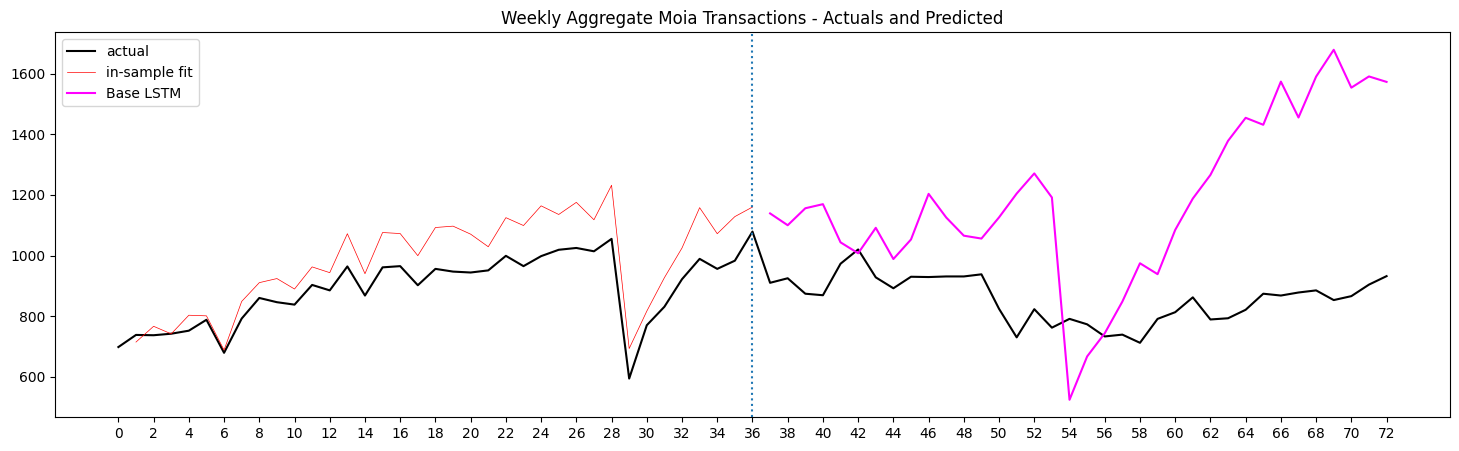

In [269]:
post_processing.show_predictions(type="full", dl_framework="tensorflow")

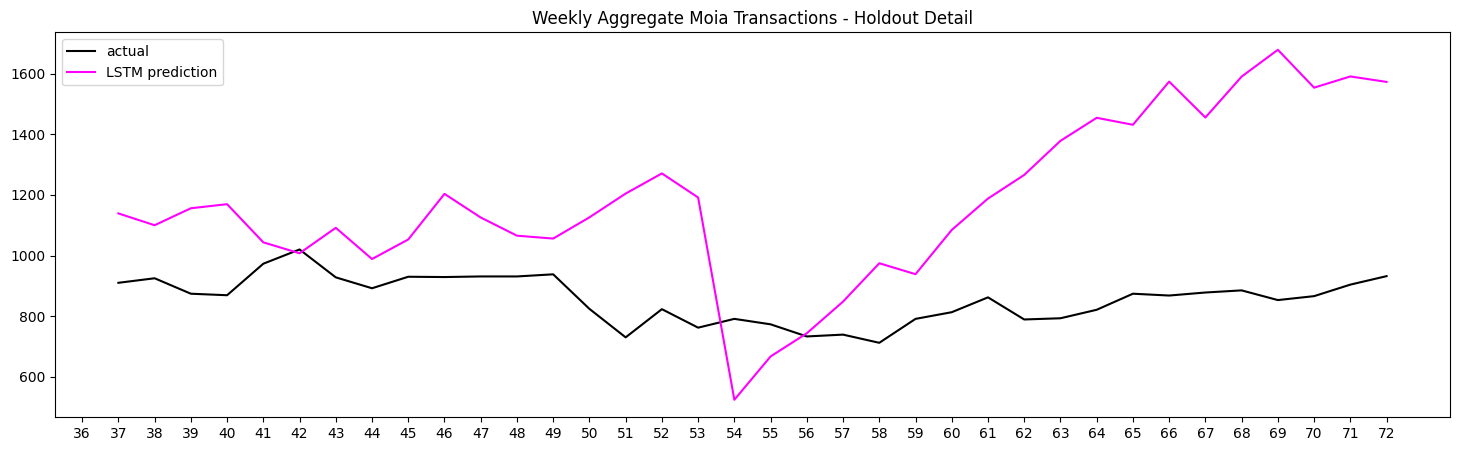

In [270]:
post_processing.show_predictions(type="out_of_sample", dl_framework="tensorflow")

## CDNOW

In [271]:
cols=["customer_id", "date", "amount", "revenue in $"]
df_cdnow = pd.read_fwf("data/CDNOW_master.txt", header=None, names= cols)
df_cdnow["date"] = pd.to_datetime(df_cdnow["date"],format='%Y%m%d')
#df_cdnow["week"] = df_cdnow["date"].dt.isocalendar().week-1
#df_cdnow["year"] = df_cdnow["date"].dt.isocalendar().year
df_cdnow.head()

,customer_id,date,amount,revenue in $
0,1,1997-01-01,1,11.77
1,2,1997-01-12,1,12.00
2,2,1997-01-12,5,77.00
3,3,1997-01-02,2,20.76
4,3,1997-03-30,2,20.76


In [272]:
training_start_cdnow = '1997-01-01'
training_end_cdnow   = '1997-09-23'
holdout_start_cdnow  = '1997-09-23'
holdout_end_cdnow    = '1998-06-30'
date_format_cdnow    = '%Y-%m-%d'

In [273]:
aggregate_counts = df_cdnow.copy(deep=True)
aggregate_counts['year'] = aggregate_counts['date'].dt.year
aggregate_counts['week'] = (aggregate_counts['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts = aggregate_counts.groupby(['year', 'week']).agg({'customer_id': 'count', 'date': 'min'}).reset_index()
aggregate_counts.shape

(78, 4)

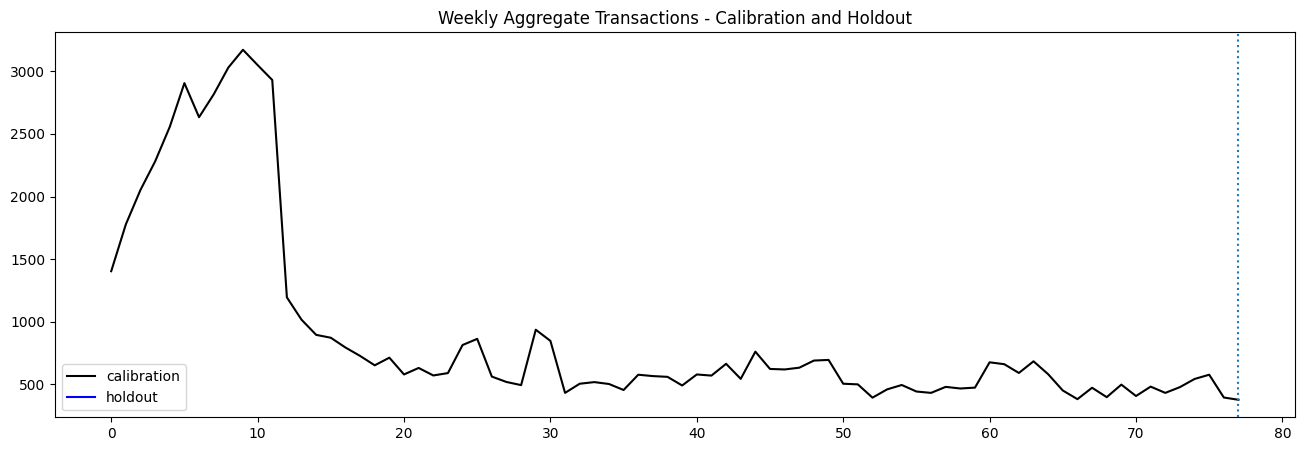

In [274]:
# display aggregate calibration and holdout transactions plot

plt.figure(figsize=(16,5))
plt.plot(aggregate_counts[aggregate_counts.date <= training_end].index, 
         aggregate_counts[aggregate_counts.date <= training_end]['customer_id'], color='black', label='calibration')
plt.plot(aggregate_counts[aggregate_counts.date >= holdout_start].index, 
         aggregate_counts[aggregate_counts.date >= holdout_start]['customer_id'], color='blue', label='holdout')
plt.axvline(len(aggregate_counts[aggregate_counts.date <= training_end])-1, linestyle=':')
plt.title('Weekly Aggregate Transactions - Calibration and Holdout')
plt.legend()
plt.show()

# note the prominent monthly pattern with spiky first weeks

In [275]:
data_prep_cdnow = preprocessing.Preprocessing(df=df_cdnow,
training_start=training_start_cdnow,
training_end=training_end_cdnow,
holdout_start=holdout_start_cdnow,
holdout_end=holdout_end_cdnow,
batch_train_size=32)

In [276]:
train_cdnow, val_cdnow = data_prep_cdnow.run(dl_framwork="tensorflow")

TRUE


preparing dataset:   0%|          | 0/23570 [00:00<?, ?it/s]

In [277]:
model_train_cdnow = train_model.TrainingModel(max_weeks=52, max_trans=25,seq_len=37,max_epoch=10, name="cd_now")
model_train_cdnow.graph()
model_train_cdnow.model_summary()
model_train_cdnow.train_model(train_dataset=train_cdnow, valid_dataset=val_cdnow,no_train_samples=data_prep_cdnow.no_train_samples,no_valid_samples=data_prep_cdnow.batch_train_size,batch_size_train=32, batch_size_val=data_prep_cdnow.no_valid_samples)

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 week (InputLayer)              [(None, 37, 1)]      0           []                               
                                                                                                  
 transaction (InputLayer)       [(None, 37, 1)]      0           []                               
                                                                                                  
 embed_week (Embedding)         (None, 37, 1, 8)     416         ['week[0][0]']                   
                                                                                                  
 embed_trans (Embedding)        (None, 37, 1, 6)     150         ['transaction[0][0]']            
                                                                                           

In [278]:
model_pred_1_cdnow= pred_model.PredictionModel(prediction_batch_size=data_prep_cdnow.no_valid_samples,model_weights_filename=model_train_cdnow.model_weights_filename, training_model= model_train_cdnow)
model_cdnow = model_pred_1_cdnow.graph()

In [279]:
post_processing_cdnow =postprocessing.Postprocessing(df= df_cdnow,
        model= model_cdnow,
        holdout_calender = data_prep_cdnow.holdout_calendar,
        calender = data_prep_cdnow.calender,
        calibration= data_prep_cdnow.calibration,
        batch_size_pred = data_prep_cdnow.no_valid_samples,
        holdout = data_prep_cdnow.holdout,
        training_end = training_end_cdnow,
        holdout_start = holdout_start_cdnow,
        name="cdnow")
post_processing_cdnow.run(dl_framework="tensorflow")

The seed shape is individuals (23570) X calibration length (38) X number of features (2)
no_samples=23570
no_timesteps=38
no_features=2
no_batches=10


simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step
(2, 23570, 77, 1)


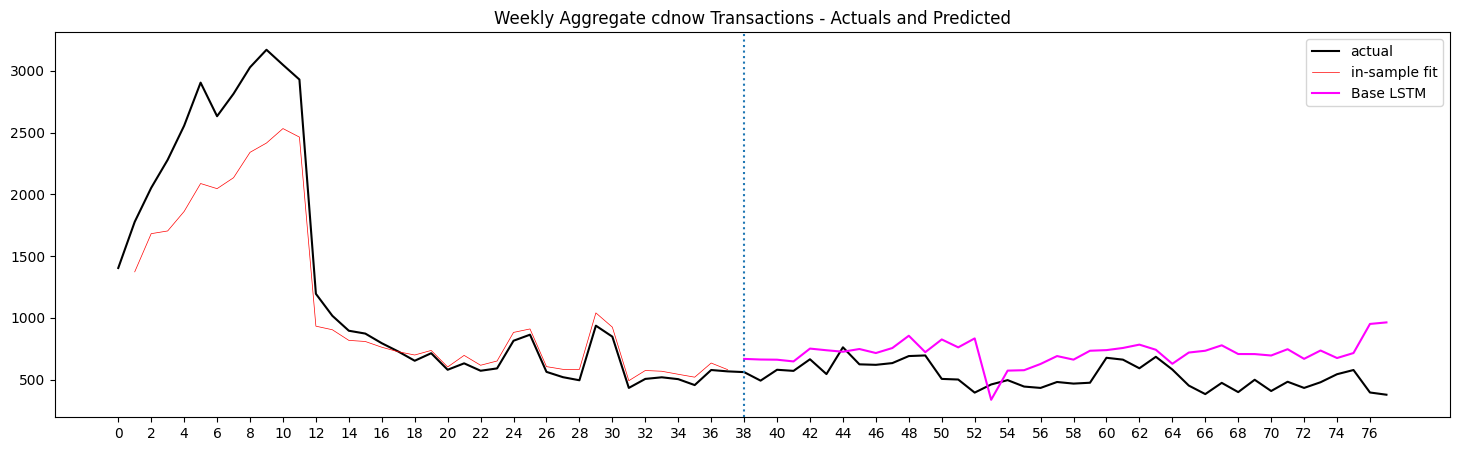

In [280]:
post_processing_cdnow.show_predictions(type="full", dl_framework="tensorflow")

In [281]:
post_processing_cdnow.show_predictions(type="self.in_sample", dl_framework="tensorflow")

No valid type.


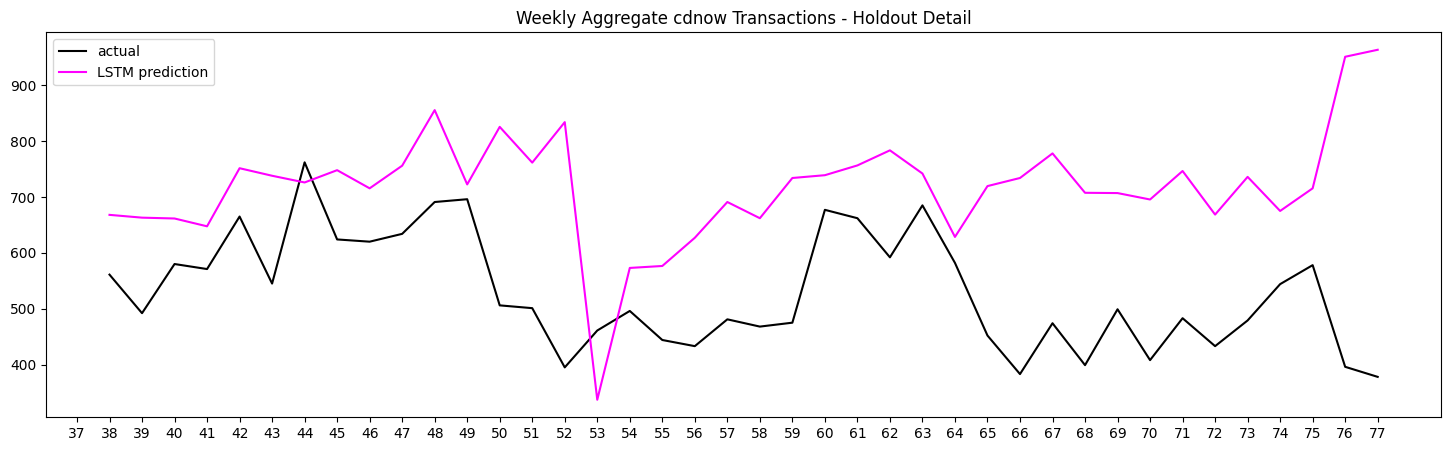

In [282]:
post_processing_cdnow.show_predictions(type="out_of_sample", dl_framework="tensorflow")

## Grocery

In [283]:
result = pyreadr.read_r('data/groceryElog.rda')
df_grocery = pd.DataFrame(result["groceryElog"])
df_grocery["date"] = pd.to_datetime(df_grocery["date"])
df_grocery = df_grocery.rename(columns={'cust': 'customer_id'})
df_grocery["customer_id"] = df_grocery["customer_id"].astype("object")
df_grocery["date"] = pd.to_datetime(df_grocery["date"],format='%Y%m%d')
df_grocery.head()

,customer_id,date
0,1,2006-01-01
1,2,2006-01-01
2,2,2006-12-19
3,3,2006-01-01
4,3,2006-01-10


In [284]:
aggregate_counts_grocery = df_grocery.copy(deep=True)
aggregate_counts_grocery['year'] = aggregate_counts_grocery['date'].dt.year
aggregate_counts_grocery['week'] = (aggregate_counts_grocery['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts_grocery = aggregate_counts_grocery.groupby(['year', 'week']).agg({'customer_id': 'count', 'date': 'min'}).reset_index()

In [285]:
training_start_grocery = "2006-01-01"
training_end_grocery = "2007-02-05"
holdout_start_grocery = "2007-01-31"
holdout_end_grocery = "2007-12-30"
date_format    = '%Y-%m-%d'

In [286]:
aggregate_counts_grocery

,year,week,customer_id,date
0,2006,0,85,2006-01-01
1,2006,1,158,2006-01-07
2,2006,2,137,2006-01-14
3,2006,3,189,2006-01-21
4,2006,4,201,2006-01-28
...,...,...,...,...
99,2007,47,58,2007-11-25
100,2007,48,53,2007-12-02
101,2007,49,64,2007-12-09
102,2007,50,59,2007-12-16


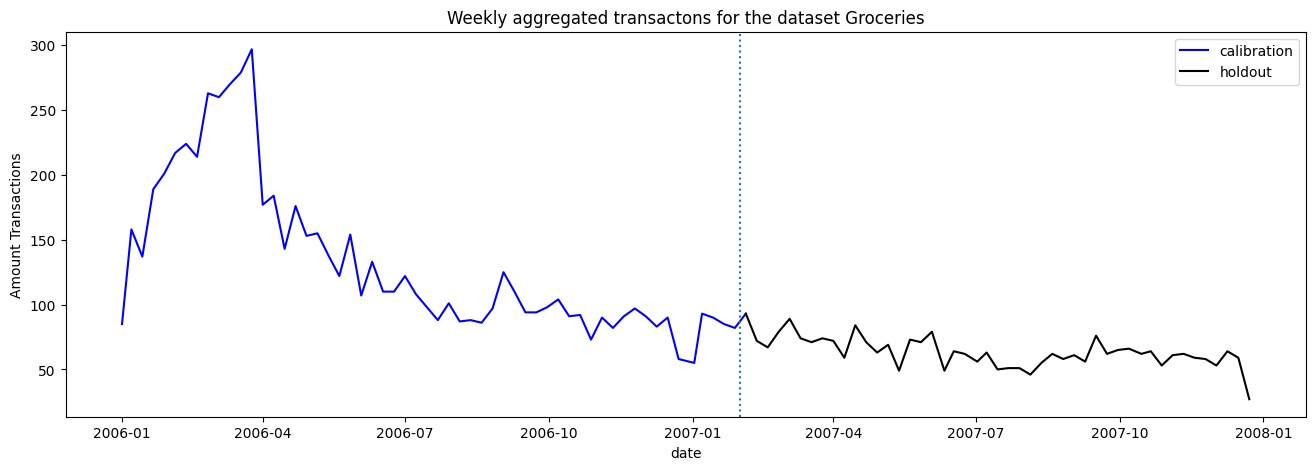

In [287]:
plt.figure(figsize=(16,5))
plt.plot(aggregate_counts_grocery[aggregate_counts_grocery.date <= "2007-02-05"]["date"], 
        aggregate_counts_grocery[aggregate_counts_grocery.date <= "2007-02-05"]["customer_id"], color='blue', label='calibration')
plt.plot(aggregate_counts_grocery[aggregate_counts_grocery.date >= "2007-01-31"]["date"], 
        aggregate_counts_grocery[aggregate_counts_grocery.date >= "2007-01-31"]["customer_id"], color='black', label='holdout')
plt.axvline(datetime.datetime(2007,1,31), linestyle=':')
plt.title('Weekly aggregated transactons for the dataset Groceries')
plt.xlabel("date")
plt.ylabel("Amount Transactions")
plt.legend()
plt.show()

In [288]:
data_prep_grocery = preprocessing.Preprocessing(df=df_grocery,
training_start=training_start_grocery,
training_end=training_end_grocery,
holdout_start=holdout_start_grocery,
holdout_end=holdout_end_grocery,
batch_train_size=32)

In [289]:
train_grocery, val_grocery = data_prep_grocery.run(dl_framwork="tensorflow")

TRUE


preparing dataset:   0%|          | 0/1525 [00:00<?, ?it/s]

In [290]:
model_train_grocery = train_model.TrainingModel(max_weeks=52, max_trans=5,seq_len=56,max_epoch=10, name="grocery")
model_train_grocery.graph()
model_train_grocery.model_summary()
model_train_grocery.train_model(train_dataset=train_grocery, valid_dataset=val_grocery,no_train_samples=data_prep_grocery.no_train_samples,no_valid_samples=data_prep_grocery.batch_train_size,batch_size_train=32, batch_size_val=data_prep_grocery.no_valid_samples)

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 week (InputLayer)              [(None, 56, 1)]      0           []                               
                                                                                                  
 transaction (InputLayer)       [(None, 56, 1)]      0           []                               
                                                                                                  
 embed_week (Embedding)         (None, 56, 1, 8)     416         ['week[0][0]']                   
                                                                                                  
 embed_trans (Embedding)        (None, 56, 1, 3)     15          ['transaction[0][0]']            
                                                                                           

In [291]:
model_pred_1_grocery= pred_model.PredictionModel(prediction_batch_size=data_prep_grocery.no_valid_samples,model_weights_filename=model_train_grocery.model_weights_filename, training_model= model_train_grocery)
model_grocery = model_pred_1_grocery.graph()

In [292]:
post_processing_grocery =postprocessing.Postprocessing(df= df_grocery,
        model= model_grocery,
        holdout_calender = data_prep_grocery.holdout_calendar,
        calender = data_prep_grocery.calender,
        calibration= data_prep_grocery.calibration,
        batch_size_pred = data_prep_grocery.no_valid_samples,
        holdout = data_prep_grocery.holdout,
        training_end = training_end_grocery,
        holdout_start = holdout_start_grocery,
        name="Grocery")
post_processing_grocery.run(dl_framework="tensorflow")

The seed shape is individuals (1525) X calibration length (57) X number of features (2)
no_samples=1525
no_timesteps=57
no_features=2
no_batches=11
147


simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step
(2, 1525, 103, 1)


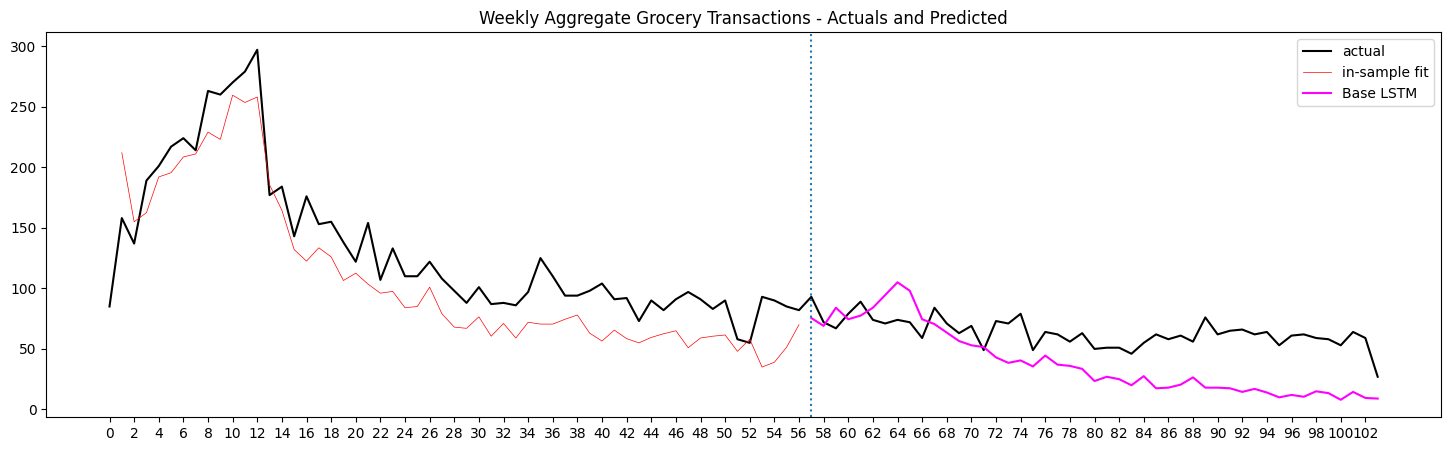

In [293]:
post_processing_grocery.show_predictions(type="full", dl_framework="tensorflow")

## UK Retail

In [294]:
# Import Dataset
df_retailer = pd.read_csv("data/uk_retail_cleaned.csv")
df_retailer["date"] = pd.to_datetime(df_retailer["date"])
df_retailer.head()

,Invoice,StockCode,Description,Quantity,date,Price,customer_id,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom


In [295]:
aggregate_counts_retail = df_retailer.copy(deep=True)
aggregate_counts_retail['year'] = aggregate_counts_retail['date'].dt.year
aggregate_counts_retail['week'] = (aggregate_counts_retail['date'].dt.dayofyear // 7).clip(upper=51) # we roll the 52nd week into the 51st
aggregate_counts_retail = aggregate_counts_retail.groupby(['year', 'week']).agg({'customer_id': 'count', 'date': 'min'}).reset_index()

In [296]:
training_start_retail = "2009-12-02"
training_end_retail = "2010-12-02"
holdout_start_retail = "2010-12-02"
holdout_end_retail = "2011-12-02"
date_format    = '%Y-%m-%d'

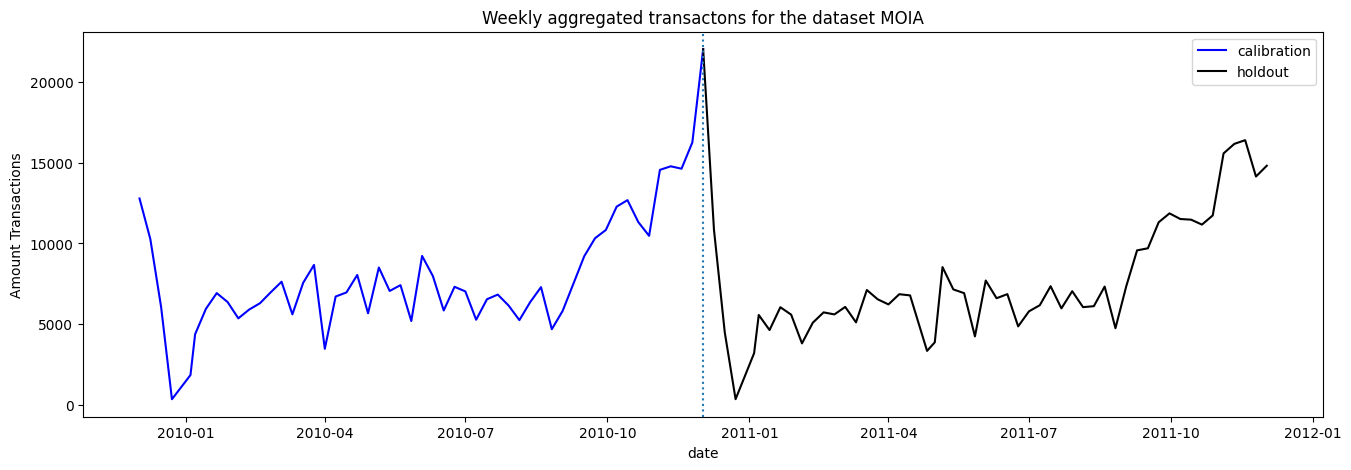

In [297]:
aggregate_counts_retail = aggregate_counts_retail[aggregate_counts_retail.date >= training_start_retail]
aggregate_counts_retail = aggregate_counts_retail[aggregate_counts_retail.date <= holdout_end_retail]
plt.figure(figsize=(16,5))
plt.plot(aggregate_counts_retail[aggregate_counts_retail.date <= training_end_retail]["date"], 
        aggregate_counts_retail[aggregate_counts_retail.date <= training_end_retail]["customer_id"], color='blue', label='calibration')
plt.plot(aggregate_counts_retail[aggregate_counts_retail.date >= training_end_retail]["date"], 
        aggregate_counts_retail[aggregate_counts_retail.date >= training_end_retail]["customer_id"], color='black', label='holdout')
plt.axvline(datetime.datetime(2010,12,2), linestyle=':')

plt.title('Weekly aggregated transactons for the dataset MOIA')
plt.xlabel("date")
plt.ylabel("Amount Transactions")
plt.legend()
plt.show()

In [298]:
data_prep_retail = preprocessing.Preprocessing(df=df_retailer,
training_start=training_start_retail,
training_end=training_end_retail,
holdout_start=holdout_start_retail,
holdout_end=holdout_end_retail,
batch_train_size=32)

In [299]:
data_prep_retail.seq_len

0

In [300]:
train_retail, val_retail = data_prep_retail.run(dl_framwork="tensorflow")

TRUE


preparing dataset:   0%|          | 0/5942 [00:00<?, ?it/s]

In [301]:
model_train_retail = train_model.TrainingModel(max_weeks=52, max_trans=725,seq_len=51,max_epoch=10, name="retail")
model_train_retail.graph()
model_train_retail.model_summary()
model_train_retail.train_model(train_dataset=train_retail, valid_dataset=val_retail,no_train_samples=data_prep_retail.no_train_samples,no_valid_samples=data_prep_retail.batch_train_size,batch_size_train=32, batch_size_val=data_prep_retail.no_valid_samples)

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 week (InputLayer)              [(None, 51, 1)]      0           []                               
                                                                                                  
 transaction (InputLayer)       [(None, 51, 1)]      0           []                               
                                                                                                  
 embed_week (Embedding)         (None, 51, 1, 8)     416         ['week[0][0]']                   
                                                                                                  
 embed_trans (Embedding)        (None, 51, 1, 27)    19575       ['transaction[0][0]']            
                                                                                           

In [302]:
model_pred_retail= pred_model.PredictionModel(prediction_batch_size=data_prep_retail.no_valid_samples,model_weights_filename=model_train_retail.model_weights_filename, training_model= model_train_retail)
model_retail = model_pred_retail.graph()

In [303]:
post_processing_retail =postprocessing.Postprocessing(df= df_retailer,
        model= model_retail,
        holdout_calender = data_prep_retail.holdout_calendar,
        calender = data_prep_retail.calender,
        calibration= data_prep_retail.calibration,
        batch_size_pred = data_prep_retail.no_valid_samples,
        holdout = data_prep_retail.holdout,
        training_end = training_end_retail,
        holdout_start = holdout_start_retail,
        name="Retail")
post_processing_retail.run(dl_framework="tensorflow")

The seed shape is individuals (5942) X calibration length (52) X number of features (2)
no_samples=5942
no_timesteps=52
no_features=2
no_batches=11
592


simulating scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step
(2, 5942, 104, 1)


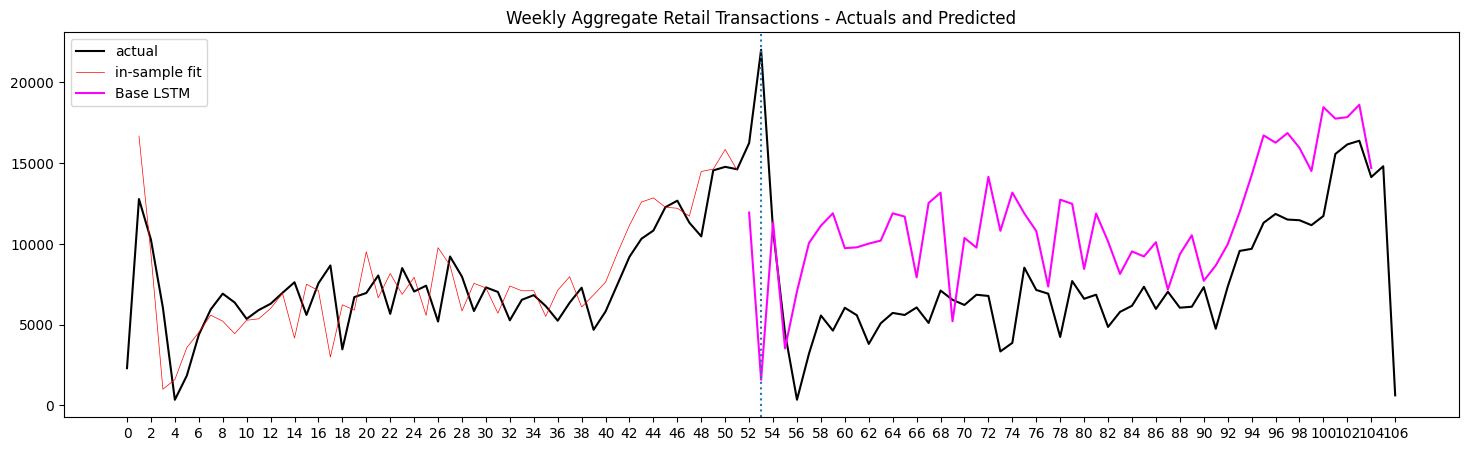

In [304]:
post_processing_retail.show_predictions(type="full", dl_framework="tensorflow")